In [69]:
%matplotlib inline

import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import graphviz
from ipywidgets import Image
from io import StringIO
import numpy as np
import pandas as pd
import random, math, sys, os, warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Data 2 is the dataset from the 1st assignment after its clearing it of missing values.

For this task we will ignore our TL (life expectancy) and use the binary variable (TL > median = 1, else 0).

In [70]:
df=pd.read_excel("../input/data2.xlsx")
print(np.median(df["Life expectancy"]))
df["LE > median"]=df["Life expectancy"].apply(lambda x: 1 if (x>70.9905) else 0)

70.9905


Kustom entropy

In [71]:
def entropy (spl):
#    print('')
#    print('split data at index ' + str(spl))
    prob=pd.value_counts(df["LE > median"][0:spl].values, normalize=True)
    et=0
    e1=0
    for x in range(len(prob)):
        try:
            e1-=prob[x]*math.log(prob[x],2)
        except:
            e1-=0
#    print('entropy of 1st group = ' + str(e1))
    
    et+=e1*spl/len(df["LE > median"])
    prob=pd.value_counts(df["LE > median"][spl:len(df["LE > median"])].values, normalize=True)
    e2=0
    for x in range(len(prob)):
        try:
            e2-=prob[x]*math.log(prob[x],2)
        except:
            e2-=0
    et+=e2*(len(df["LE > median"])-spl)/len(df["LE > median"])
#    print('entropy of 2nd group = ' + str(e2))
#    print('entropy total = ' + str(et), 'info gain = ' + str(1-et))
    return (e1,e2,et)

Gini entropy

In [73]:
def gini (spl):
#    print('')
#    print('split data at index ' + str(spl))
    prob=pd.value_counts(df['LE > median'][0:spl].values, normalize=True)
    et=0
    if len(prob) > 1:
        e1=1
    else:
        e1=0
    for x in range(len(prob)):
        if len(prob) > 1:
            e1-=prob[x]*prob[x]
#    print('entropy of 1st group = ' + str(e1))
    
    et+=e1*spl/len(df['LE > median'])
    prob=pd.value_counts(df['LE > median'][spl:len(df['LE > median'])].values, normalize=True)
    if len(prob) > 1:
        e2=1
    else:
        e2=0
    for x in range(len(prob)):
        if len(prob) > 1:
            e2-=prob[x]*prob[x]
    et+=e2*(len(df['LE > median'])-spl)/len(df['LE > median'])
#    print('entropy of 2nd group = ' + str(e2))
#    print('entropy total = ' + str(et), 'info gain = ' + str(0.5-et))
    return (e1,e2,et)

In [74]:
print("Full df entropy = " + str(entropy(0)[2]))
print("Full df gini = " + str(gini(0)[2]))
print("")
print("df entropy (split = 300) = " + str(entropy(300)[2]) + ", info gain = " + str((entropy(0)[2]-entropy(300)[2])))
print("df gini (split = 300) = " + str(gini(300)[2]) + ", info gain = " + str((gini(0)[2]-gini(300)[2])))

Full df entropy = 1.0
Full df gini = 0.5

df entropy (split = 300) = 0.9999961863478518, info gain = 3.8136521481879626e-06
df gini (split = 300) = 0.4999973565952948, info gain = 2.6434047051826504e-06


In [75]:
features=df.columns.tolist()
features.remove('Country Name')
features.remove('LE > median')
features.remove('Life expectancy')
ent_min = 1
ent_min1 = []
f_min=""
i_min=0
ent_ming=0.5
ent_ming1 = []
f_ming=""
i_ming=0
for feature in features:
    df=df.sort_values(by=feature)
    for i in range(len(df)):
        x = entropy(i)[2]
        z = gini(i)[2]
        if x < ent_min:
            ent_min = x
            ent_min1 = entropy(i)
            f_min = feature
            i_min = i
        if z < ent_ming:
            ent_ming = z
            ent_ming1 = gini(i)
            f_ming = feature
            i_ming = i 
print("Entropy:")
print (["%0.3f" % i for i in ent_min1])
print(f_min)
df=df.sort_values(by=f_min)
print(df[f_min][i_min-1:i_min+1])
print("")
print("Gini:")
print (["%0.3f" % i for i in ent_ming1])
print(f_ming)
df=df.sort_values(by=f_ming)
print(df[f_ming][i_ming-1:i_ming+1])
print("")

Entropy:
['0.399', '0.789', '0.639']
GDP US$ per capita ln
1857   7.882
1426   7.883
Name: GDP US$ per capita ln, dtype: float64

Gini:
['0.186', '0.340', '0.276']
GDP US$ per capita ln
2663   8.001
2752   8.002
Name: GDP US$ per capita ln, dtype: float64



Same result as built-in functions, except it takes 5 minutes to process.

Tree (depth 3) and accuracy score on full dataset, entropy and gini:

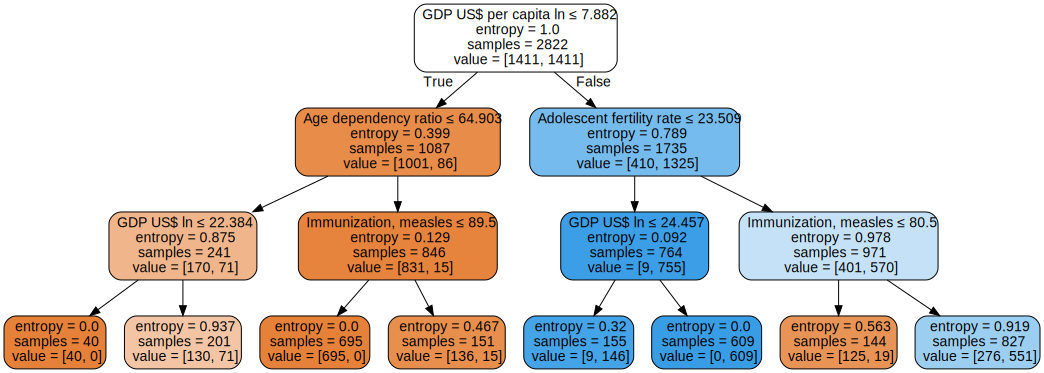

In [76]:
df2=df.drop(labels = ['Country Name', 'LE > median', 'Life expectancy'], axis = 1)
tree1 = DecisionTreeClassifier(max_depth=3, random_state=17, criterion = "entropy").fit(df2, df['LE > median'])
graph = graphviz.Source(export_graphviz(tree1, out_file=None,feature_names=list(df2.columns.values),filled=True,rounded=True,special_characters=True))
graph

In [77]:
predictions=tree1.predict(df2)
print ("Acc based on entropy:")
print ("%0.3f" % accuracy_score(df['LE > median'], predictions))

Acc based on entropy:
0.862


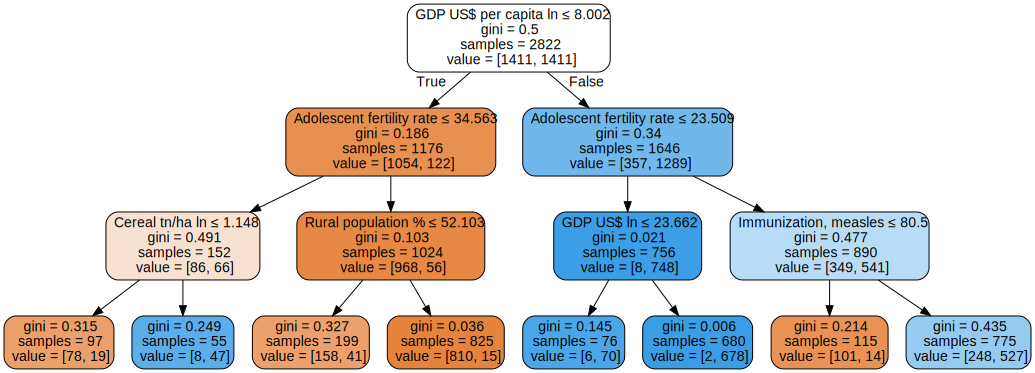

In [78]:
df2=df.drop(labels = ['Country Name', 'LE > median', 'Life expectancy'], axis = 1)
tree1 = DecisionTreeClassifier(max_depth=3, random_state=17).fit(df2, df['LE > median'])
graph = graphviz.Source(export_graphviz(tree1, out_file=None,feature_names=list(df2.columns.values),filled=True,rounded=True,special_characters=True))
graph

In [79]:
predictions=tree1.predict(df2)
print ("Acc based on Gini:")
print("%0.3f" % accuracy_score(df['LE > median'], predictions))

Acc based on Gini:
0.875


Training tree on 1000 observations and testing accuracy on the rest of the dataset:

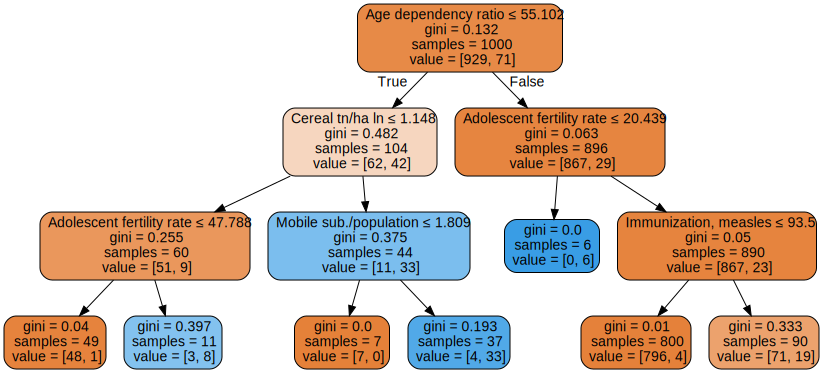

In [80]:
tree1 = DecisionTreeClassifier(max_depth=3, random_state=17).fit(df2.iloc[0:1000,:], df['LE > median'][0:1000])
graph = graphviz.Source(export_graphviz(tree1, out_file=None,feature_names=list(df2.iloc[0:1000,:].columns.values),filled=True,rounded=True,special_characters=True))
graph

In [81]:
predictions=tree1.predict(df2.iloc[1001:len(df2),:])
print("%0.3f" % accuracy_score(df['LE > median'][1001:len(df2)], predictions))

0.716


Grid search:

Tried using KFold to randomly select items to be used in test samples. Train acc. 0.928, test 0.834. Acc. drop because the initial dataset is sorted, so test and train subsets (split at index 2000) still have different mean values.

In [82]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid={'max_depth': range(2,30)}, scoring = 'accuracy', cv = KFold(n_splits=5, shuffle=True, random_state=17))
gs.fit(df2.iloc[:2000,:], df['LE > median'][:2000])
print(gs.best_params_)
print("%0.3f" % gs.best_score_)
predictions=gs.predict(df2.iloc[2001:len(df2),:])
x=accuracy_score(df['LE > median'][2001:len(df2)], predictions)
print("%0.3f" % x)

{'max_depth': 14}
0.928
0.834


The same with initially randomly shuffled dataset:

In [83]:
df3=df.drop(labels = ['Country Name', 'Life expectancy'], axis = 1)
random.seed(17)
idx=random.sample([i for i in range(len(df2))], len(df2))
df3=df3.iloc[idx]

In [84]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=17), param_grid={'max_depth': range(2,30)}, scoring = 'accuracy', cv = 5)
gs.fit(df3.drop(labels = ['LE > median'], axis = 1).iloc[:2000,:], df3['LE > median'][:2000])
print(gs.best_params_)
print("%0.3f" % gs.best_score_)
predictions=gs.predict(df3.drop(labels = ['LE > median'], axis = 1).iloc[2001:len(df3),:])
x=accuracy_score(df3['LE > median'][2001:len(df3)], predictions)
print("%0.3f" % x)

{'max_depth': 12}
0.929
0.935


Somehow test shown better accuracy even though tree has possibly overlearned.

Final tree based on the best GS estimator.

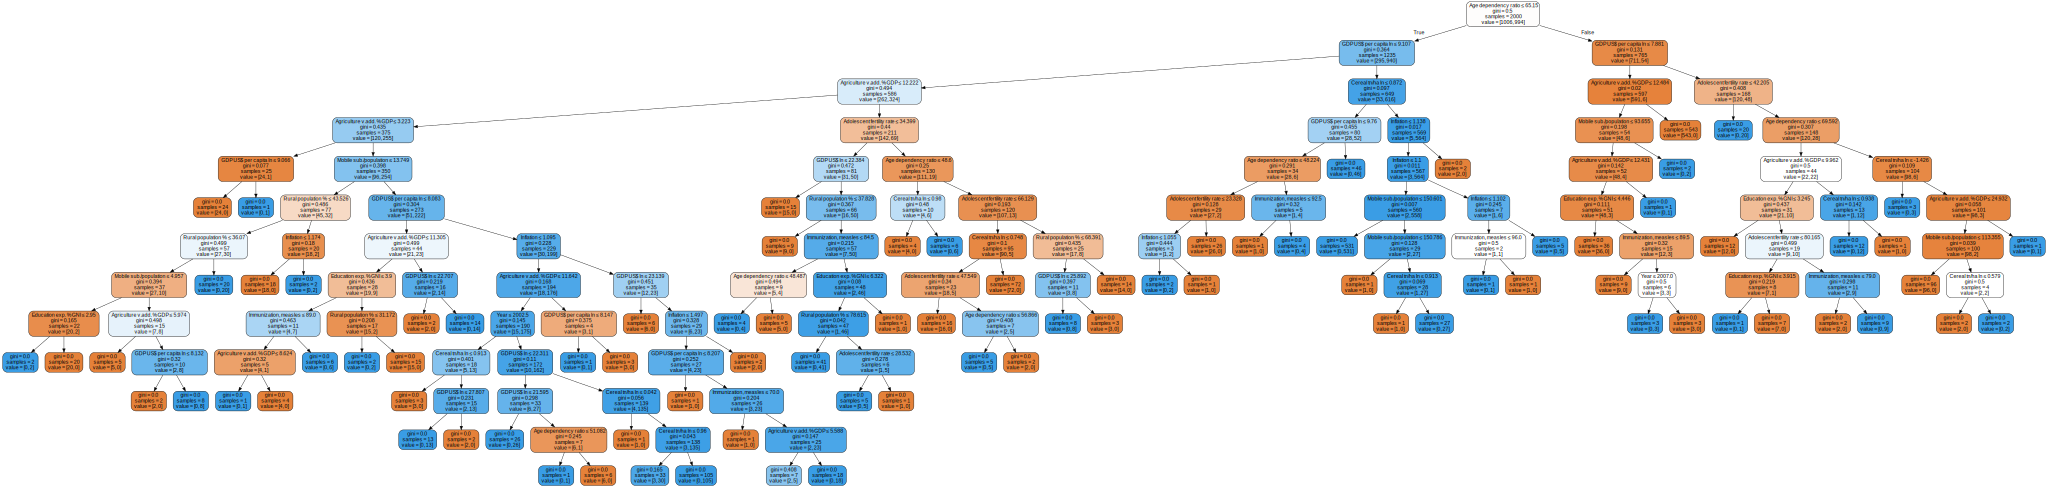

In [85]:
graph = graphviz.Source(export_graphviz(gs.best_estimator_, out_file=None,feature_names=list(df2.columns.values),filled=True,rounded=True,special_characters=True))
graph